In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    "green1": "#66c2a5",
    "orange": "#fc8d62",
    "blue": "#8da0cb",
    "pink": "#e78ac3",
    "green2": "#a6d854",
    "yellow": "#ffd92f",
    "brown": "#e5c494",
    "grey": "#b3b3b3",
}

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [4]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [5]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [6]:
import pandas as pd
from astropy.table import Table

In [7]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

In [9]:
# UVOT
joj_UVOT = pd.read_csv(
    "./UVOT_light_curve.dat",
    delimiter=" ",
    names=["time", "flux", "fluxerr", "mag", "mag_unc_u", "mag_unc_l", "lim", "band"],
)
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"]
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"]
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"]
joj_UVOT_u = joj_UVOT[joj_UVOT["band"] == "U"].assign(band="uvot::u")
joj_UVOT_b = joj_UVOT[joj_UVOT["band"] == "B"].assign(band="uvot::b")
joj_UVOT_v = joj_UVOT[joj_UVOT["band"] == "V"].assign(band="uvot::v")
joj_UVOT = pd.concat([joj_UVOT_b, joj_UVOT_v])

In [10]:
# ATLAS
joj_ATLAS = pd.read_csv("./atlas_forced_phot.txt", delimiter=" ", names=["MJD", "m", "dm", "uJy", "duJy", "F", "err", "chi/N", "RA", "Dec", "x", "y", "maj", "min", "phi", "apfit", "mag5sig", "Sky", "Obs"])
joj_ATLAS = np.loadtxt("./atlas_forced_phot.txt", dtype=object)
# joj_ATLAS = joj_ATLAS[:, [0, 2, 3, ]]
joj_ATLAS = joj_ATLAS[:, [0, 3, 4, 5]]
joj_ATLAS[:, :-1] = np.array(joj_ATLAS[:, :-1], dtype=float)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS[:, -1] == "o"]
arg = ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) <= 48) & ((joj_ATLAS_o[:, 0] - t_max_mjd) / (1 + z) >= -48)
joj_ATLAS_o[:, -1] = "atlaso"
joj_ATLAS_o = joj_ATLAS_o[arg]
joj_ATLAS_o = pd.DataFrame(joj_ATLAS_o, columns=["time", "flux", "fluxerr", "band"])

In [11]:
joj_UCB = pd.read_csv("./UCB_phot.dat", comment='#', sep="\t")

## Early rise

In [12]:
import pymc as pm
import arviz as az

In [12]:
joj_ZTF_r_rise = joj_ZTF_r[
    ((joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z) <= 0)
    & ((joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z) >= -25)
    & (joj_ZTF_r["fnu_microJy"]/joj_ZTF_r["fnu_microJy"].max() <= 0.4)
]

In [13]:
### MJD          m      dm   uJy   duJy F err chi/N     RA       Dec        x        y     maj  min   phi  apfit mag5sig Sky   Obs
with open("./atlas_forced_phot.txt") as f:
    lines = f.readlines()
joj_ATLAS = {"MJD":[], "fnu_microJy":[], "fnu_microJy_unc":[], "passband":[]}
for l in lines[1:]:
    dat = l.split()
    joj_ATLAS["MJD"] = np.append(joj_ATLAS["MJD"], float(dat[0]))
    joj_ATLAS["fnu_microJy"] = np.append(joj_ATLAS["fnu_microJy"], float(dat[3]))
    joj_ATLAS["fnu_microJy_unc"] = np.append(joj_ATLAS["fnu_microJy_unc"], float(dat[4]))
    joj_ATLAS["passband"] = np.append(joj_ATLAS["passband"], dat[5])
joj_ATLAS = pd.DataFrame(joj_ATLAS)
joj_ATLAS_o = joj_ATLAS[joj_ATLAS["passband"] == "o"]
joj_ATLAS_o_rise = joj_ATLAS_o[
    ((joj_ATLAS_o["MJD"] - t_max_mjd) / (1 + z) <= 0)
    & ((joj_ATLAS_o["MJD"] - t_max_mjd) / (1 + z) >= -25)
    & (joj_ATLAS_o["fnu_microJy"]/joj_ATLAS_o["fnu_microJy"].max() <= 0.4)
]

In [25]:
MJD_pred = np.linspace(-25, -10, 100) + t_max_mjd
with pm.Model() as rise_MJD:
    t_exp = pm.Uniform(
        "t_exp", joj_ZTF_r_rise["MJD"].values[0], joj_ZTF_r_rise["MJD"].values[-1]
    )
    alpha_ZTF = pm.Normal("alpha_ZTF", 2, 1)
    log_A_ZTF = pm.Uniform("log_A_ZTF", 0, 2)
    phase_ZTF = joj_ZTF_r_rise["MJD"].values - t_exp
    flux_ZTF = pm.Deterministic(
        "flux_ZTF", 10**log_A_ZTF * ((phase_ZTF + np.abs(phase_ZTF)) / 2) ** alpha_ZTF
    )
    alpha_ATLAS = pm.Normal("alpha_ATLAS", 2, 1)
    log_A_ATLAS = pm.Uniform("log_A_ATLAS", 0, 2)
    phase_ATLAS = joj_ATLAS_o_rise["MJD"].values - t_exp
    flux_ATLAS = pm.Deterministic(
        "flux_ATLAS",
        10**log_A_ATLAS * ((phase_ATLAS + np.abs(phase_ATLAS)) / 2) ** alpha_ATLAS,
    )
    flux_obs_ZTF = pm.Normal(
        "flux_obs_ZTF",
        flux_ZTF,
        joj_ZTF_r_rise["fnu_microJy_unc"].values,
        observed=joj_ZTF_r_rise["fnu_microJy"].values,
    )
    flux_obs_ATLAS = pm.Normal(
        "flux_obs_ATLAS",
        flux_ATLAS,
        joj_ATLAS_o_rise["fnu_microJy_unc"].values,
        observed=joj_ATLAS_o_rise["fnu_microJy"].values,
    )
    flux_pred_ZTF = pm.Deterministic(
        "flux_pred_ZTF",
        10**log_A_ZTF
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ZTF,
    )
    flux_pred_ATLAS = pm.Deterministic(
        "flux_pred_ATLAS",
        10**log_A_ATLAS
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ATLAS,
    )
    trace_MJD = pm.sample(return_inferencedata=True, tune=5000, target_accept=0.95)

with pm.Model() as rise_alpha2_MJD:
    t_exp = pm.Uniform(
        "t_exp", joj_ZTF_r_rise["MJD"].values[0], joj_ZTF_r_rise["MJD"].values[-1]
    )
    alpha_ZTF = 2
    log_A_ZTF = pm.Uniform("log_A_ZTF", 0, 2)
    phase_ZTF = (joj_ZTF_r_rise["MJD"].values - t_exp)
    flux_ZTF = pm.Deterministic(
        "flux_ZTF", 10**log_A_ZTF * ((phase_ZTF + np.abs(phase_ZTF)) / 2) ** alpha_ZTF
    )
    alpha_ATLAS = 2
    log_A_ATLAS = pm.Uniform("log_A_ATLAS", 0, 2)
    phase_ATLAS = (joj_ATLAS_o_rise["MJD"].values - t_exp)
    flux_ATLAS = pm.Deterministic(
        "flux_ATLAS",
        10**log_A_ATLAS * ((phase_ATLAS + np.abs(phase_ATLAS)) / 2) ** alpha_ATLAS,
    )
    flux_obs_ZTF = pm.Normal(
        "flux_obs_ZTF",
        flux_ZTF,
        joj_ZTF_r_rise["fnu_microJy_unc"].values,
        observed=joj_ZTF_r_rise["fnu_microJy"].values,
    )
    flux_obs_ATLAS = pm.Normal(
        "flux_obs_ATLAS",
        flux_ATLAS,
        joj_ATLAS_o_rise["fnu_microJy_unc"].values,
        observed=joj_ATLAS_o_rise["fnu_microJy"].values,
    )
    flux_pred_ZTF = pm.Deterministic(
        "flux_pred_ZTF",
        10**log_A_ZTF
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2) ** alpha_ZTF,
    )
    flux_pred_ATLAS = pm.Deterministic(
        "flux_pred_ATLAS",
        10**log_A_ATLAS
        * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp)) / 2)
        ** alpha_ATLAS,
    )
    trace_MJD_alpha2 = pm.sample(return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_exp, alpha_ZTF, log_A_ZTF, alpha_ATLAS, log_A_ATLAS]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 111 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_exp, log_A_ZTF, log_A_ATLAS]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


In [26]:
summary = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if not 'flux' in var])
summary_pred = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if 'pred' in var])
summary

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_ZTF,2.179,0.209,1.944,2.384,0.008,0.005,749.0,970.0,1.0
alpha_ATLAS,2.312,0.360,2.113,2.789,0.012,0.008,939.0,1112.0,1.0
t_exp,59703.158,0.600,59702.583,59703.855,0.022,0.015,761.0,1100.0,1.0
log_A_ZTF,0.567,0.258,0.321,0.866,0.009,0.007,746.0,983.0,1.0
log_A_ATLAS,0.446,0.327,0.000,0.560,0.011,0.008,833.0,1069.0,1.0


In [24]:
summary_alpha2 = az.summary(trace_MJD_alpha2, hdi_prob=0.68, var_names=[var for var in trace_MJD_alpha2.posterior.data_vars if not 'flux' in var])
summary_alpha2_pred = az.summary(trace_MJD_alpha2, hdi_prob=0.68, var_names=[var for var in trace_MJD_alpha2.posterior.data_vars if 'pred' in var])
summary_alpha2

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_exp,59703.658,0.111,59703.548,59703.765,0.003,0.002,1151.0,1307.0,1.0
log_A_ZTF,0.788,0.015,0.774,0.804,0.000,0.000,1144.0,1160.0,1.0
log_A_ATLAS,0.778,0.023,0.757,0.802,0.001,0.000,1448.0,1594.0,1.0


In [20]:
t_fl_mjd = 59703.136
t_fl_mjd_up, t_fl_mjd_lo = 59703.759, 59702.566
t_max_mjd_B = 59723.13
rise_time = (t_max_mjd_B - t_fl_mjd) / (1 + z)
rise_time

19.461532471576444

(-50.0, 550.0)

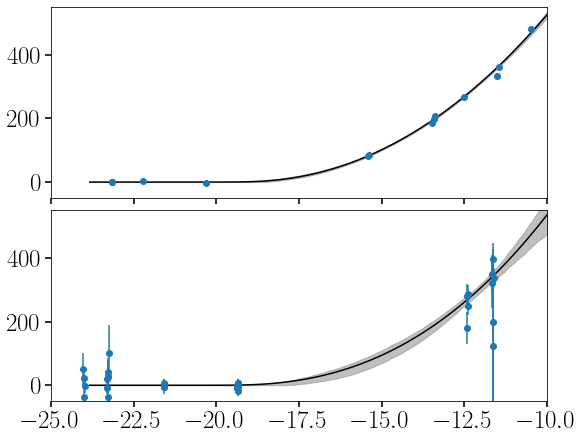

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
pred_ZTF = summary_pred.loc[summary_pred.index[:100]]
pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax[0].plot((MJD_pred - t_max_mjd_B) / (1 + z), pred_ZTF["mean"], color="k")
ax[0].fill_between(
    (MJD_pred - t_max_mjd_B) / (1 + z), pred_ZTF["hdi_16%"], pred_ZTF["hdi_84%"], color="0.5", alpha=0.5
)
ax[0].errorbar(
    (joj_ZTF_r_rise["MJD"].values - t_max_mjd_B) / (1 + z),
    joj_ZTF_r_rise["fnu_microJy"].values,
    yerr=joj_ZTF_r_rise["fnu_microJy_unc"].values,
    fmt="o",
)
ax[1].plot((MJD_pred - t_max_mjd_B) / (1 + z), pred_ATLAS["mean"], color="k")
ax[1].fill_between(
    (MJD_pred - t_max_mjd_B) / (1 + z), pred_ATLAS["hdi_16%"], pred_ATLAS["hdi_84%"], color="0.5", alpha=0.5
)
ax[1].errorbar(
    (joj_ATLAS_o_rise["MJD"].values - t_max_mjd_B) / (1 + z),
    joj_ATLAS_o_rise["fnu_microJy"].values,
    yerr=joj_ATLAS_o_rise["fnu_microJy_unc"].values,
    fmt="o",
)
# plt.yscale('log')
plt.xlim(-25, -10)
ax[0].set_ylim(-50, 550)
ax[1].set_ylim(-50, 550)
# plt.yscale("log")

### Polynomial

In [13]:
def peak_poly_fit(MJD, mag_obs, mag_obs_unc, z=0, t_max_0=59723):
    MJD_pred = np.linspace(-20, 20, 100) + t_max_0
    with pm.Model() as peak:
        # t_max = pm.Uniform("t_max", 59721, 59724)
        t_max = pm.Normal("t_max", t_max_0, 5)

        a4 = pm.Uniform("a4", -1e-2, 1e-2)
        a3 = pm.Uniform("a3", -1e-2, 1e-2)
        a2 = pm.Uniform("a2", -1e-2, 1e-2)
        a0 = pm.Uniform("a0", mag_obs.min() - 0.5, mag_obs.min() + 0.5)

        phase = (MJD - t_max) / (1 + z)
        phase_pred = (MJD_pred - t_max) / (1 + z)
        mag = pm.Deterministic(
            "mag",
            a4 * phase**4 + a3 * phase**3 + a2 * phase**2 + a0,
        )
        mag_obs = pm.Normal("mag_obs", mag, mag_obs_unc, observed=mag_obs)
        mag_pred = pm.Deterministic(
            "mag_pred",
            a4 * phase_pred**4 + a3 * phase_pred**3 + a2 * phase_pred**2 + a0,
        )
        dt = 15
        delta_m_15 = pm.Deterministic(
            "delta_m_15", a4 * dt**4 + a3 * dt**3 + a2 * dt**2
        )
        trace_peak = pm.sample(return_inferencedata=True, tune=2000)
    return trace_peak

In [72]:
joj_ZTF_g_peak = joj_ZTF_g[
    ((joj_ZTF_g["MJD"] - 59723.94) / (1 + z) <= 20)
    & ((joj_ZTF_g["MJD"] - 59723.94) / (1 + z) >= -10)
]
joj_ZTF_r_peak = joj_ZTF_r[
    ((joj_ZTF_r["MJD"] - 59725.05) / (1 + z) <= 10)
    & ((joj_ZTF_r["MJD"] - 59725.05) / (1 + z) >= -10)
]

trace_peak_g = peak_poly_fit(
    MJD=joj_ZTF_g_peak["MJD"].values,
    mag_obs=joj_ZTF_g_peak["mag"].values,
    mag_obs_unc=joj_ZTF_g_peak["mag_err_l"].values,
    z=z,
    t_max_0=59723.94
)
trace_peak_r = peak_poly_fit(
    MJD=joj_ZTF_r_peak["MJD"].values,
    mag_obs=joj_ZTF_r_peak["mag"].values,
    mag_obs_unc=joj_ZTF_r_peak["mag_err_l"].values,
    z=z,
    t_max_0=59725.05
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6043, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6828, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


In [73]:
summary_g_peak = az.summary(
    trace_peak_g,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_g.posterior.data_vars if not "mag" in var],
)
summary_pred_g_peak = az.summary(
    trace_peak_g,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_g.posterior.data_vars if "pred" in var],
)
summary_g_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59722.661634,0.205289,59722.460980,59722.862710,5.767030e-03,4.078850e-03,1274.843798,1348.634143,1.004785
a4,0.000007,0.000003,0.000004,0.000009,1.000000e-07,7.000000e-08,694.336269,845.762271,1.001603
a3,-0.000352,0.000083,-0.000432,-0.000260,3.280000e-06,2.320000e-06,643.765650,838.893911,1.002162
a2,0.008374,0.000660,0.007719,0.009082,2.587000e-05,1.833000e-05,645.416594,759.046110,1.003052
a0,15.813615,0.013765,15.799169,15.826212,4.625900e-04,3.272200e-04,887.074272,1456.519263,1.003191
delta_m_15,1.027408,0.028022,0.997629,1.052816,6.116500e-04,4.325600e-04,2099.280586,2338.405165,1.003443


In [74]:
summary_r_peak = az.summary(
    trace_peak_r,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_r.posterior.data_vars if not "mag" in var],
)
summary_pred_r_peak = az.summary(
    trace_peak_r,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_r.posterior.data_vars if "pred" in var],
)
summary_r_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59725.540431,0.088424,59725.448616,59725.626504,2.367790e-03,1.674630e-03,1397.388251,1965.929586,1.001267
a4,-0.000022,0.000004,-0.000025,-0.000017,1.200000e-07,8.000000e-08,1243.532957,1466.532222,1.002297
a3,0.000041,0.000018,0.000024,0.000060,5.000000e-07,3.500000e-07,1291.018640,1575.562697,1.000605
a2,0.007768,0.000300,0.007480,0.008079,8.350000e-06,5.920000e-06,1287.947623,1510.014383,1.002489
a0,15.974079,0.003775,15.970315,15.977884,8.453000e-05,5.978000e-05,1997.503099,1907.499641,1.001107
delta_m_15,0.786670,0.109211,0.679728,0.893717,2.724960e-03,1.927190e-03,1605.706096,1988.624332,1.001392


In [75]:
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
print(
    "M_g,max = {:.3f} +/- {:.3f}".format(
        summary_g_peak["mean"].loc["a0"] - calALambda(wv=leff_g, RV=3.1, EBV=ebv) - mu,
        summary_g_peak["sd"].loc["a0"],
    )
)
print(
    "M_r,max = {:.3f} +/- {:.3f}".format(
        summary_r_peak["mean"].loc["a0"] - calALambda(wv=leff_r, RV=3.1, EBV=ebv) - mu,
        summary_r_peak["sd"].loc["a0"],
    )
)

M_g,max = -19.693 +/- 0.014
M_r,max = -19.492 +/- 0.004


<ErrorbarContainer object of 3 artists>

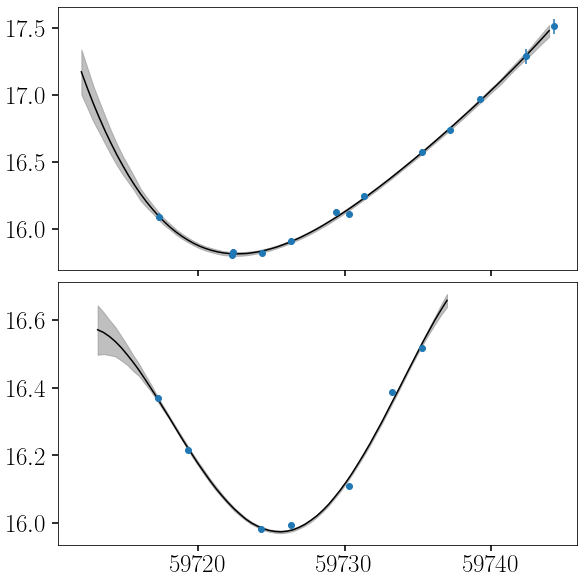

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax[0].plot(
    np.linspace(-20, 20, 100)[20:] + 59723.94,
    summary_pred_g_peak["mean"][20:],
    color="k",
)
ax[0].fill_between(
    np.linspace(-20, 20, 100)[20:] + 59723.94,
    summary_pred_g_peak["hdi_16%"][20:],
    summary_pred_g_peak["hdi_84%"][20:],
    color="0.5",
    alpha=0.5,
)
ax[0].errorbar(
    joj_ZTF_g_peak["MJD"].values,
    joj_ZTF_g_peak["mag"].values,
    yerr=joj_ZTF_g_peak["mag_err_l"].values,
    fmt="o",
)

ax[1].plot(
    np.linspace(-20, 20, 100)[20:80] + 59725.05,
    summary_pred_r_peak["mean"][20:80],
    color="k",
)
ax[1].fill_between(
    np.linspace(-20, 20, 100)[20:80] + 59725.05,
    summary_pred_r_peak["hdi_16%"][20:80],
    summary_pred_r_peak["hdi_84%"][20:80],
    color="0.5",
    alpha=0.5,
)
ax[1].errorbar(
    joj_ZTF_r_peak["MJD"].values,
    joj_ZTF_r_peak["mag"].values,
    yerr=joj_ZTF_r_peak["mag_err_l"].values,
    fmt="o",
)

In [14]:
UCB_arg = ((joj_UCB["MJD"] - 59723) / (1 + z) <= 20) & (
    (joj_UCB["MJD"] - 59723) / (1 + z) >= -15
)

trace_peak_B = peak_poly_fit(
    MJD=joj_UCB["MJD"][UCB_arg & ~np.isnan(joj_UCB["B"])].values,
    mag_obs=joj_UCB["B"][UCB_arg & ~np.isnan(joj_UCB["B"])].values,
    mag_obs_unc=joj_UCB["EB"][UCB_arg & ~np.isnan(joj_UCB["B"])].values,
    z=z,
    t_max_0=59723,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


In [63]:
UCB_arg = ((joj_UCB["MJD"] - 59723) / (1 + z) <= 15) & (
    (joj_UCB["MJD"] - 59723) / (1 + z) >= -15
)

trace_peak_V = peak_poly_fit(
    MJD=joj_UCB["MJD"][UCB_arg & ~np.isnan(joj_UCB["V"])].values,
    mag_obs=joj_UCB["V"][UCB_arg & ~np.isnan(joj_UCB["V"])].values,
    mag_obs_unc=joj_UCB["EV"][UCB_arg & ~np.isnan(joj_UCB["V"])].values,
    z=z,
    t_max_0=59725,
)
trace_peak_R = peak_poly_fit(
    MJD=joj_UCB["MJD"][UCB_arg & ~np.isnan(joj_UCB["R"])].values,
    mag_obs=joj_UCB["R"][UCB_arg & ~np.isnan(joj_UCB["R"])].values,
    mag_obs_unc=joj_UCB["ER"][UCB_arg & ~np.isnan(joj_UCB["R"])].values,
    z=z,
    t_max_0=59725,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1249, but should be close to 0.8. Try to increase the number of tuning steps.


In [87]:
UCB_arg = ((joj_UCB["MJD"] - 59720) / (1 + z) <= 20) & (
    (joj_UCB["MJD"] - 59720) / (1 + z) >= -10
)
trace_peak_I = peak_poly_fit(
    MJD=joj_UCB["MJD"][UCB_arg & ~np.isnan(joj_UCB["I"])].values,
    mag_obs=joj_UCB["I"][UCB_arg & ~np.isnan(joj_UCB["I"])].values,
    mag_obs_unc=joj_UCB["EI"][UCB_arg & ~np.isnan(joj_UCB["I"])].values,
    z=z,
    t_max_0=59720,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8856, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
summary_B_peak = az.summary(
    trace_peak_B,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_B.posterior.data_vars if not "mag" in var],
)
summary_pred_B_peak = az.summary(
    trace_peak_B,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_B.posterior.data_vars if "pred" in var],
)
summary_B_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59722.712764,0.239369,59722.438449,59722.916553,5.922250e-03,4.188410e-03,1634.791423,2345.348112,1.004203
a4,0.000011,0.000005,0.000006,0.000016,1.300000e-07,9.000000e-08,1465.031826,2046.369214,1.003174
a3,-0.000370,0.000077,-0.000440,-0.000288,2.160000e-06,1.530000e-06,1279.508709,1862.061082,1.004425
a2,0.009807,0.000176,0.009770,0.010000,3.950000e-06,2.790000e-06,1792.482259,1673.166714,1.001206
a0,16.067718,0.010721,16.057439,16.078503,2.384000e-04,1.686000e-04,2029.185319,2144.751622,1.002089
delta_m_15,1.502984,0.106647,1.397230,1.603590,1.871380e-03,1.323390e-03,3203.757923,3304.583643,1.002293


(59710.0, 59740.0)

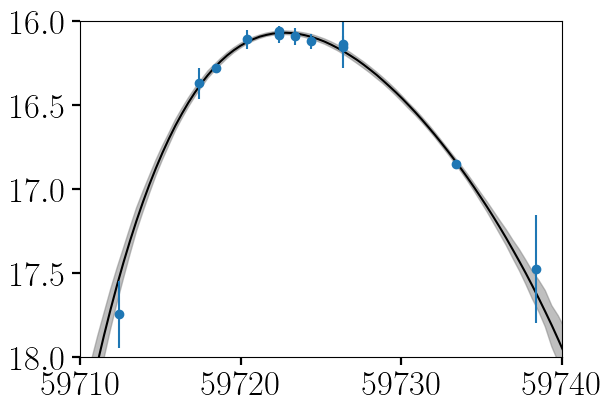

In [21]:
fig, ax = plt.subplots(figsize=(6, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    np.linspace(-20, 20, 100) + 59723,
    summary_pred_B_peak["mean"],
    color="k",
)
ax.fill_between(
    np.linspace(-20, 20, 100) + 59723,
    summary_pred_B_peak["hdi_16%"],
    summary_pred_B_peak["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar(
    joj_UCB["MJD"].values,
    joj_UCB["B"].values,
    yerr=joj_UCB["EB"].values,
    fmt="o",
)

ax.set_ylim(18., 16.)
ax.set_xlim(59710, 59740)

In [65]:
summary_V_peak = az.summary(
    trace_peak_V,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_V.posterior.data_vars if not "mag" in var],
)
summary_pred_V_peak = az.summary(
    trace_peak_V,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_V.posterior.data_vars if "pred" in var],
)
summary_V_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,5.972488e+04,0.276897,59724.581013,59725.127671,6.400000e-03,4.526190e-03,1882.703610,2296.620200,1.001352
a4,9.600000e-07,0.000005,-0.000004,0.000006,1.200000e-07,8.000000e-08,1743.408514,1856.643554,1.003055
a3,-1.371100e-04,0.000047,-0.000185,-0.000094,1.120000e-06,7.900000e-07,1822.447190,2019.021413,1.002155
a2,5.826600e-03,0.000548,0.005346,0.006455,1.319000e-05,9.360000e-06,1727.645157,1849.436860,1.003626
a0,1.594447e+01,0.009313,15.936498,15.954907,1.910200e-04,1.350900e-04,2373.703515,2614.801452,1.001324
delta_m_15,8.968730e-01,0.255879,0.634846,1.122756,6.327330e-03,4.499930e-03,1644.558890,1860.429668,1.002175


In [66]:
summary_R_peak = az.summary(
    trace_peak_R,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_R.posterior.data_vars if not "mag" in var],
)
summary_pred_R_peak = az.summary(
    trace_peak_R,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_R.posterior.data_vars if "pred" in var],
)
summary_R_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59724.606989,0.276097,5.972429e+04,59724.835960,6.523710e-03,4.613710e-03,1790.841283,1788.046197,1.001875
a4,0.000005,0.000004,5.700000e-07,0.000009,1.000000e-07,7.000000e-08,1833.266251,1994.464717,1.001336
a3,-0.000155,0.000043,-1.953300e-04,-0.000113,1.020000e-06,7.200000e-07,1784.269789,1739.482037,1.001070
a2,0.005585,0.000512,5.091750e-03,0.006111,1.226000e-05,8.760000e-06,1749.488090,1734.900328,1.001828
a0,15.970660,0.008630,1.596260e+01,15.979611,1.832800e-04,1.296200e-04,2256.013632,2095.221092,1.001088
delta_m_15,0.982256,0.196598,7.555014e-01,1.129156,4.831100e-03,3.516670e-03,1716.936827,1623.168359,1.001819


In [88]:
summary_I_peak = az.summary(
    trace_peak_I,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_I.posterior.data_vars if not "mag" in var],
)
summary_pred_I_peak = az.summary(
    trace_peak_I,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_I.posterior.data_vars if "pred" in var],
)
summary_I_peak

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,59720.728312,0.273003,59720.415720,59720.952762,7.030480e-03,4.972270e-03,1531.528722,1541.442524,1.002539
a4,0.000015,0.000004,0.000012,0.000020,1.100000e-07,8.000000e-08,1328.898420,1297.457157,1.001338
a3,-0.000649,0.000086,-0.000747,-0.000577,2.590000e-06,1.830000e-06,1136.331139,1104.025693,1.001769
a2,0.009282,0.000519,0.009101,0.009997,1.462000e-05,1.034000e-05,1177.434405,1309.203476,1.000741
a0,16.211146,0.011400,16.199104,16.221575,2.784200e-04,1.969200e-04,1680.408539,1749.518461,1.000374
delta_m_15,0.661146,0.049331,0.609071,0.706478,9.832000e-04,6.953100e-04,2522.867075,3066.477261,1.001122


In [89]:
leff_B = 4354.45  # AA
leff_V = 5336.14  # AA
leff_R = 6306.93  # AA
leff_I = 8802.84  # AA
print(
    "M_B,max = {:.3f} +/- {:.3f}".format(
        summary_B_peak["mean"].loc["a0"] - calALambda(wv=leff_B, RV=3.1, EBV=ebv) - mu,
        summary_B_peak["sd"].loc["a0"],
    )
)
print(
    "M_V,max = {:.3f} +/- {:.3f}".format(
        summary_V_peak["mean"].loc["a0"] - calALambda(wv=leff_V, RV=3.1, EBV=ebv) - mu,
        summary_V_peak["sd"].loc["a0"],
    )
)
print(
    "M_R,max = {:.3f} +/- {:.3f}".format(
        summary_R_peak["mean"].loc["a0"] - calALambda(wv=leff_R, RV=3.1, EBV=ebv) - mu,
        summary_R_peak["sd"].loc["a0"],
    )
)
print(
    "M_I,max = {:.3f} +/- {:.3f}".format(
        summary_I_peak["mean"].loc["a0"] - calALambda(wv=leff_I, RV=3.1, EBV=ebv) - mu,
        summary_I_peak["sd"].loc["a0"],
    )
)

M_B,max = -19.456 +/- 0.011
M_V,max = -19.544 +/- 0.009
M_R,max = -19.496 +/- 0.009
M_I,max = -19.222 +/- 0.011


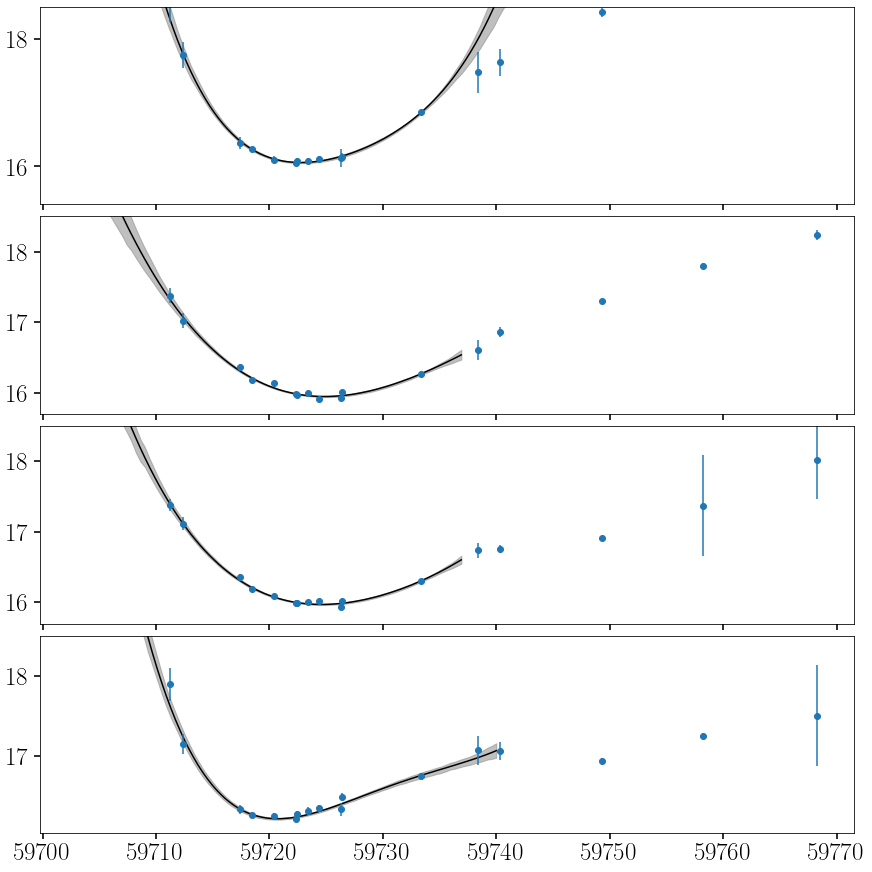

In [92]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax[0].plot(
    np.linspace(-20, 20, 100) + 59723,
    summary_pred_B_peak["mean"],
    color="k",
)
ax[0].fill_between(
    np.linspace(-20, 20, 100) + 59723,
    summary_pred_B_peak["hdi_16%"],
    summary_pred_B_peak["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax[0].errorbar(
    joj_UCB["MJD"].values,
    joj_UCB["B"].values,
    yerr=joj_UCB["EB"].values,
    fmt="o",
)

ax[1].plot(
    np.linspace(-20, 20, 100)[:80] + 59725,
    summary_pred_V_peak["mean"][:80],
    color="k",
)
ax[1].fill_between(
    np.linspace(-20, 20, 100)[:80] + 59725,
    summary_pred_V_peak["hdi_16%"][:80],
    summary_pred_V_peak["hdi_84%"][:80],
    color="0.5",
    alpha=0.5,
)
ax[1].errorbar(
    joj_UCB["MJD"].values,
    joj_UCB["V"].values,
    yerr=joj_UCB["EV"].values,
    fmt="o",
)

ax[2].plot(
    np.linspace(-20, 20, 100)[:80] + 59725,
    summary_pred_R_peak["mean"][:80],
    color="k",
)
ax[2].fill_between(
    np.linspace(-20, 20, 100)[:80] + 59725,
    summary_pred_R_peak["hdi_16%"][:80],
    summary_pred_R_peak["hdi_84%"][:80],
    color="0.5",
    alpha=0.5,
)
ax[2].errorbar(
    joj_UCB["MJD"].values,
    joj_UCB["R"].values,
    yerr=joj_UCB["ER"].values,
    fmt="o",
)

ax[3].plot(
    np.linspace(-20, 20, 100)[20:] + 59720,
    summary_pred_I_peak["mean"][20:],
    color="k",
)
ax[3].fill_between(
    np.linspace(-20, 20, 100)[20:] + 59720,
    summary_pred_I_peak["hdi_16%"][20:],
    summary_pred_I_peak["hdi_84%"][20:],
    color="0.5",
    alpha=0.5,
)
ax[3].errorbar(
    joj_UCB["MJD"].values,
    joj_UCB["I"].values,
    yerr=joj_UCB["EI"].values,
    fmt="o",
)

for a in ax:
    a.set_ylim(None, 18.5)

## Fit other SNe

In [95]:
# SN 2011fe
g_fe = np.loadtxt("./SN2011fe/SN2011fe_g_synthetic.dat")

t_fl_fe = 55796.687
t_max_mjd_fe = 55814.5

fe_g_peak = g_fe[
    ((g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008) <= 20)
    & ((g_fe[:, 0] - t_max_mjd_fe) / (1 + 0.0008) >= -10)
]

trace_peak_fe = peak_poly_fit(
    MJD=fe_g_peak[:, 0],
    mag_obs=fe_g_peak[:, 1],
    mag_obs_unc=fe_g_peak[:, 2],
    z=0.0008,
    t_max_0=t_max_mjd_fe
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,55814.874559,5.682200e-04,55814.873948,55814.875068,1.710000e-05,1.209000e-05,1116.425404,1358.064203,1.002746
a4,0.000010,1.000000e-08,0.000010,0.000010,0.000000e+00,0.000000e+00,1271.189027,1866.280974,1.002485
a3,-0.000340,1.200000e-07,-0.000340,-0.000339,0.000000e+00,0.000000e+00,1095.815042,1545.754375,1.003119
a2,0.006486,7.400000e-07,0.006485,0.006486,2.000000e-08,1.000000e-08,1675.532353,2259.011574,1.002272
a0,9.890724,2.240000e-05,9.890703,9.890746,5.300000e-07,3.800000e-07,1786.209394,2234.362789,1.000446
delta_m_15,0.796856,8.347000e-05,0.796770,0.796934,2.200000e-06,1.550000e-06,1452.120122,2260.022658,1.001483


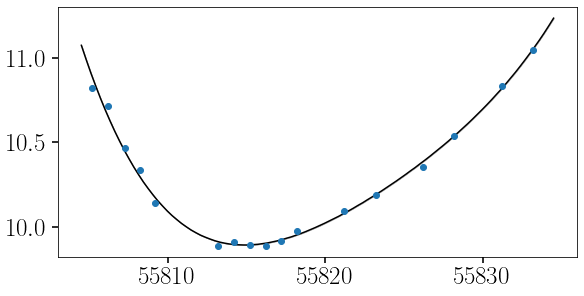

In [97]:
summary_fe = az.summary(
    trace_peak_fe,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_fe.posterior.data_vars if not "mag" in var],
)
summary_pred_fe = az.summary(
    trace_peak_fe,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_fe.posterior.data_vars if "pred" in var],
)
MJD_pred = np.linspace(-10, 20, 100) + t_max_mjd_fe
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    MJD_pred,
    summary_pred_fe["mean"],
    color="k",
)
ax.fill_between(
    MJD_pred,
    summary_pred_fe["hdi_16%"],
    summary_pred_fe["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar(
    fe_g_peak[:, 0],
    fe_g_peak[:, 1],
    yerr=fe_g_peak[:, 2],
    fmt="o",
)
summary_fe

In [102]:
# SN2018cnw
raw = pd.read_csv("./color/early18ia/ZTF18abauprj.dat", sep=" ")
lc_g = np.array(raw)[:, :-1][raw["fid"] == 1]  # determine the first detection

cnw_peak = lc_g[
    ((lc_g[:, 0]) <= 20)
    & ((lc_g[:, 0]) >= -10)
]

trace_peak_cnw = peak_poly_fit(
    MJD=cnw_peak[:, 0],
    mag_obs=cnw_peak[:, 1],
    mag_obs_unc=cnw_peak[:, 2],
    z=0.0242,
    t_max_0=0
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_max, a4, a3, a2, a0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_max,0.566898,8.126525e-02,0.487946,0.647095,2.483230e-03,1.772810e-03,1078.999064,1114.562650,1.000756
a4,0.000002,5.300000e-07,0.000001,0.000002,2.000000e-08,1.000000e-08,1092.914348,1350.077628,1.001715
a3,-0.000116,1.057000e-05,-0.000127,-0.000106,3.300000e-07,2.300000e-07,1032.888157,1069.684666,1.001163
a2,0.004794,5.639000e-05,0.004729,0.004841,1.310000e-06,9.300000e-07,1842.342489,2047.046874,0.999653
a0,-19.564166,2.522390e-03,-19.566477,-19.561455,5.866000e-05,4.149000e-05,1844.556874,1931.542814,0.999544
delta_m_15,0.772198,9.266650e-03,0.762895,0.781066,2.681400e-04,1.898300e-04,1200.510184,1540.572984,1.001374


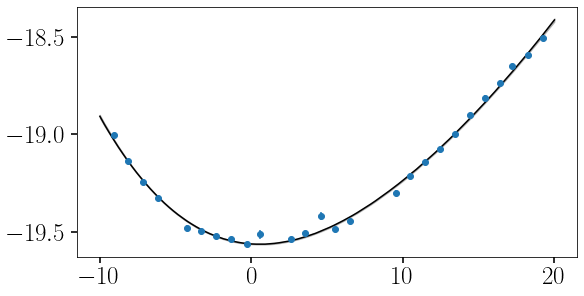

In [103]:
summary_cnw = az.summary(
    trace_peak_cnw,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_peak_cnw.posterior.data_vars if not "mag" in var],
)
summary_pred_cnw = az.summary(
    trace_peak_cnw,
    hdi_prob=0.68,
    var_names=[var for var in trace_peak_cnw.posterior.data_vars if "pred" in var],
)
MJD_pred = np.linspace(-10, 20, 100)
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    MJD_pred,
    summary_pred_cnw["mean"],
    color="k",
)
ax.fill_between(
    MJD_pred,
    summary_pred_cnw["hdi_16%"],
    summary_pred_cnw["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar(
    cnw_peak[:, 0],
    cnw_peak[:, 1],
    yerr=cnw_peak[:, 2],
    fmt="o",
)
summary_cnw

# $s_{BV}$

In [123]:
def sBV_fit(MJD, BV_obs, BV_obs_unc, z=0, tB_max=59723):
    MJD_pred = np.linspace(0, 50, 100) + tB_max
    with pm.Model() as BV:
        s0 = pm.Uniform("s0", 0, 0.15)
        s1 = pm.Uniform("s1", -0.02, 0)
        tau = pm.Normal("tau", 10, 2)
        t_h = pm.Uniform("t_h", 10, 50)
        C = pm.Uniform("C", -0.5, 0.5)

        phase = (MJD - tB_max) / (1 + z)
        phase_pred = (MJD_pred - tB_max) / (1 + z)
        BV = pm.Deterministic(
            "B-V",
            0.5 * (s0 + s1) * phase
            + 0.5 * tau * (s1 - s0) * pm.math.log(pm.math.cosh((phase - t_h) / tau))
            + C,
        )
        obs = pm.Normal("obs", BV, BV_obs_unc, observed=BV_obs)
        BV_pred = pm.Deterministic(
            "B-V_pred",
            0.5 * (s0 + s1) * phase_pred
            + 0.5
            * tau
            * (s1 - s0)
            * pm.math.log(pm.math.cosh((phase_pred - t_h) / tau))
            + C,
        )
        pm.Deterministic("s_BV", (0.5 * tau * pm.math.log(-s0 / s1) + t_h) / 30)
        trace_BV = pm.sample(return_inferencedata=True, tune=2000, target_accept=0.95)
    return trace_BV

In [137]:
UCB_arg = (joj_UCB["MJD"] - 59722.767776) / (1 + z) >= 2

MJD = joj_UCB["MJD"][UCB_arg].values
B = joj_UCB["B"][UCB_arg].values
B_err = joj_UCB["EB"][UCB_arg].values
V = joj_UCB["V"][UCB_arg].values
V_err = joj_UCB["EV"][UCB_arg].values

f1 = 10 ** (-0.4 * B)
f1_err = f1 * B_err * np.log(10) / 2.5

f2 = 10 ** (-0.4 * V)
f2_err = f2 * V_err * np.log(10) / 2.5

f12 = f1 / f2
B_V = -2.5 * np.log10(f12)
delta_f12 = ((f1_err / f1) ** 2 + (f2_err / f2) ** 2) ** 0.5 * f12
B_V_err = delta_f12 / f12 * 2.5 / np.log(10)

In [138]:
trace_BV = sBV_fit(
    MJD=MJD[~np.isnan(B_V)],
    BV_obs=B_V[~np.isnan(B_V)],
    BV_obs_unc=B_V_err[~np.isnan(B_V)],
    z=z,
    tB_max=59722.767776,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s0, s1, tau, t_h, C]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


In [139]:
summary_BV = az.summary(
    trace_BV,
    hdi_prob=0.68,
    round_to=8,
    var_names=[var for var in trace_BV.posterior.data_vars if not "B-V" in var],
)
summary_pred_BV = az.summary(
    trace_BV,
    hdi_prob=0.68,
    var_names=[var for var in trace_BV.posterior.data_vars if "pred" in var],
)
summary_BV

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,10.788564,1.794956,9.158551,12.581907,0.044314,0.031931,1658.660433,1945.190613,1.002852
s0,0.077307,0.015017,0.059521,0.085991,0.000580,0.000414,730.548187,949.249076,1.007809
s1,-0.008269,0.005202,-0.010786,-0.000034,0.000125,0.000092,1668.409206,1562.383171,1.002026
t_h,17.582524,2.572390,16.002193,20.925535,0.095014,0.067212,747.584703,798.421514,1.008530
C,0.330109,0.120122,0.287770,0.498837,0.004284,0.003030,849.306974,950.810058,1.010455
s_BV,1.040877,0.160536,0.878315,1.093158,0.003719,0.002677,2197.444427,1847.383148,1.001974


<ErrorbarContainer object of 3 artists>

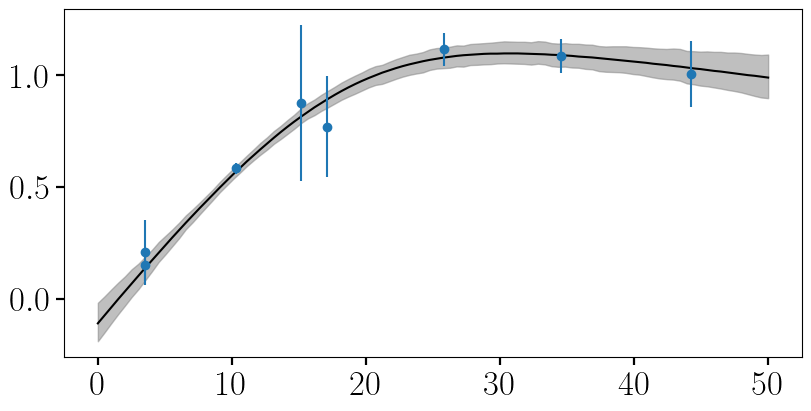

In [140]:
MJD_pred = np.linspace(0, 50, 100)
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, constrained_layout=True)
# pred_ZTF = summary_pred.loc[summary_.index[:100]]
# pred_ATLAS = summary_pred.loc[summary_pred.index[100:]]
ax.plot(
    MJD_pred,
    summary_pred_BV["mean"],
    color="k",
)
ax.fill_between(
    MJD_pred,
    summary_pred_BV["hdi_16%"],
    summary_pred_BV["hdi_84%"],
    color="0.5",
    alpha=0.5,
)
ax.errorbar((MJD - 59722.767776) / (1 + z), B_V, yerr=B_V_err, fmt="o")
# summary_cnw